In [2]:
# API scrape 
from psaw import PushshiftAPI

# Basic libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

Data Scrape
I chose to scrape posts from r/TheOnion and r/nottheonion in order to create a fake news model that could accurately distinguish between fake news and absurd news. From each subbreddit I scraped the following information:

title: title of subreddit post
subreddit: which subreddit the post belongs to
num_comments: the number of comments for a post
author: author's username of a post
subreddit_subcribers: number of subcribers for that subreddit
score: the score received on reddit
domain: the domain referenced in the post
created_utc: date and time the post was created

In [3]:
#API Scrape Function
def scrape_data(subreddit):
    
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit=subreddit,
                                filter=['title', 'subreddit', 'num_comments', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=15000))

    #Filter list to only show Subreddit titles and Subreddit category 
    clean_scrape_lst = []
    for i in range(len(scrape_list)):
        scrape_dict = {}
        scrape_dict['subreddit'] = scrape_list[i][5]
        scrape_dict['author'] = scrape_list[i][0]
        scrape_dict['domain'] = scrape_list[i][2]
        scrape_dict['title'] = scrape_list[i][7]
        scrape_dict['num_comments'] = scrape_list[i][3]
        scrape_dict['score'] = scrape_list[i][4]
        scrape_dict['timestamp'] = scrape_list[i][1]
        clean_scrape_lst.append(scrape_dict)

    # Show number of subscribers
    print(subreddit, 'subscribers:',scrape_list[1][6])
    
    # Return list of scraped data
    return clean_scrape_lst

In [4]:
# Call function and create DataFrame
df_not_onion = pd.DataFrame(scrape_data('nottheonion'))

# Save data to csv
df_not_onion.to_csv('./data/not_onion.csv')



nottheonion subscribers: 15815873


In [5]:
# Shape of DataFrame
print(f'df_not_onion shape: {df_not_onion.shape}')

# Show head
df_not_onion.head()

df_not_onion shape: (15000, 7)


,author,domain,num_comments,score,subreddit,timestamp,title
0,One_Day_Dead,ign.com,2,1,nottheonion,1570207585,Wendy's Made a Tabletop RPG Where You Battle R...
1,mrjoepete,thedrive.com,0,1,nottheonion,1570206800,Volkswagen Golf R used as Getaway Car in $6 Mi...
2,PapayaSF,thejc.com,1,1,nottheonion,1570206630,University and College Union apologises after ...
3,SuperCub,wtvm.com,1,1,nottheonion,1570206381,Florida woman didn’t get enough tomatoes so sh...
4,Planeguy58,cnn.com,0,1,nottheonion,1570205951,Kamala Harris calls on Twitter CEO to suspend ...


In [6]:
# Call function and create DataFrame
df_onion = pd.DataFrame(scrape_data('theonion'))

# Save data to csv
df_onion.to_csv('./data/the_onion.csv')

# Shape of DataFrame
print(f'df_onion shape: {df_onion.shape}')

# Show head
df_onion.head()

theonion subscribers: 121514
df_onion shape: (15000, 7)


,author,domain,num_comments,score,subreddit,timestamp,title
0,dwaxe,clickhole.com,1,1,TheOnion,1570205550,Cool It: This High Schooler Is Really Milking ...
1,Zeno_Fobya,theonion.com,1,1,TheOnion,1570201215,This article from 2011 should be archived as a...
2,aresef,politics.theonion.com,1,1,TheOnion,1570136115,Kamala Harris Undergoes Heart Surgery After Se...
3,aresef,lifestyle.clickhole.com,0,1,TheOnion,1570131253,6 Pictures Of Scarlett Johansson That Will Mak...
4,aresef,politics.theonion.com,0,1,TheOnion,1570130996,Justin Trudeau Explains Deep Spiritual Signifi...


In [7]:
# r/TheOnion DataFrame
df_onion = pd.read_csv('./data/the_onion.csv')

# r/nottheonion DataFrame
df_not_onion = pd.read_csv('./data/not_onion.csv')

In [8]:
# Show first 5 rows of df_onion
print("Shape:", df_onion.shape)
df_onion.head()

Shape: (15000, 8)


,Unnamed: 0,author,domain,num_comments,score,subreddit,timestamp,title
0,0,dwaxe,clickhole.com,1,1,TheOnion,1570205550,Cool It: This High Schooler Is Really Milking ...
1,1,Zeno_Fobya,theonion.com,1,1,TheOnion,1570201215,This article from 2011 should be archived as a...
2,2,aresef,politics.theonion.com,1,1,TheOnion,1570136115,Kamala Harris Undergoes Heart Surgery After Se...
3,3,aresef,lifestyle.clickhole.com,0,1,TheOnion,1570131253,6 Pictures Of Scarlett Johansson That Will Mak...
4,4,aresef,politics.theonion.com,0,1,TheOnion,1570130996,Justin Trudeau Explains Deep Spiritual Signifi...


In [9]:
df_onion.drop(['Unnamed: 0'],axis=1,inplace=True)


In [10]:
# Show first 5 rows of df_not_onion
print("Shape:", df_not_onion.shape)
df_not_onion.head()

Shape: (15000, 8)


,Unnamed: 0,author,domain,num_comments,score,subreddit,timestamp,title
0,0,One_Day_Dead,ign.com,2,1,nottheonion,1570207585,Wendy's Made a Tabletop RPG Where You Battle R...
1,1,mrjoepete,thedrive.com,0,1,nottheonion,1570206800,Volkswagen Golf R used as Getaway Car in $6 Mi...
2,2,PapayaSF,thejc.com,1,1,nottheonion,1570206630,University and College Union apologises after ...
3,3,SuperCub,wtvm.com,1,1,nottheonion,1570206381,Florida woman didn’t get enough tomatoes so sh...
4,4,Planeguy58,cnn.com,0,1,nottheonion,1570205951,Kamala Harris calls on Twitter CEO to suspend ...


In [11]:
df_not_onion.drop(['Unnamed: 0'],axis=1,inplace=True)

In [12]:
def clean_data(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='title', inplace=True)
    
    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

In [13]:
# Call `clean_data(dataframe)` function
clean_data(df_onion)

New shape: (14224, 7)


,author,domain,num_comments,score,subreddit,timestamp,title
0,dwaxe,clickhole.com,1,1,TheOnion,1570205550,cool it this high schooler is really milking t...
1,Zeno_Fobya,theonion.com,1,1,TheOnion,1570201215,this article from should be archived as a cla...
2,aresef,politics.theonion.com,1,1,TheOnion,1570136115,kamala harris undergoes heart surgery after se...
3,aresef,lifestyle.clickhole.com,0,1,TheOnion,1570131253,pictures of scarlett johansson that will make...
4,aresef,politics.theonion.com,0,1,TheOnion,1570130996,justin trudeau explains deep spiritual signifi...


In [14]:
# Call `clean_data(dataframe)` function
clean_data(df_not_onion)

New shape: (11860, 7)


,author,domain,num_comments,score,subreddit,timestamp,title
0,One_Day_Dead,ign.com,2,1,nottheonion,1570207585,wendy s made a tabletop rpg where you battle r...
1,mrjoepete,thedrive.com,0,1,nottheonion,1570206800,volkswagen golf r used as getaway car in milli...
2,PapayaSF,thejc.com,1,1,nottheonion,1570206630,university and college union apologises after ...
3,SuperCub,wtvm.com,1,1,nottheonion,1570206381,florida woman didn t get enough tomatoes so sh...
4,Planeguy58,cnn.com,0,1,nottheonion,1570205951,kamala harris calls on twitter ceo to suspend ...


In [15]:
# Create a DataFrame to check nulls
pd.DataFrame([df_onion.isnull().sum(),df_not_onion.isnull().sum()], index=["TheOnion","notheonion"]).T

,TheOnion,notheonion
author,0,0
domain,0,0
num_comments,0,0
score,0,0
subreddit,0,0
timestamp,0,0
title,0,0


In [16]:
# Convert Unix Timestamp to Datetime
df_onion['timestamp'] = pd.to_datetime(df_onion['timestamp'], unit='s')
df_not_onion['timestamp'] = pd.to_datetime(df_not_onion['timestamp'], unit='s')

# Show date-range of posts scraped from r/TheOnion and r/nottheonion
print("TheOnion start date:", df_onion['timestamp'].min())
print("TheOnion end date:", df_onion['timestamp'].max())
print("nottheonion start date:", df_not_onion['timestamp'].min())
print("nottheonion end date:", df_not_onion['timestamp'].max())

TheOnion start date: 2015-07-27 06:25:47
TheOnion end date: 2019-10-04 16:12:30
nottheonion start date: 2019-07-17 23:23:21
nottheonion end date: 2019-10-04 16:46:25


In [17]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

r/TheOnion: Most Active Authors

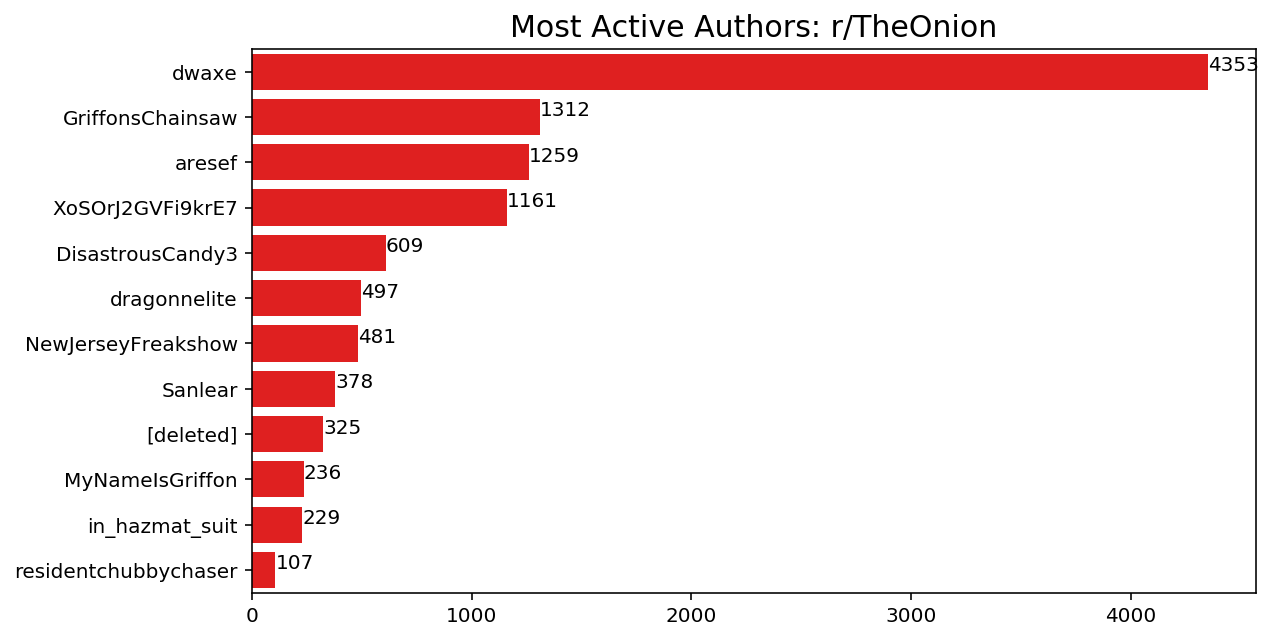

In [18]:
# Set x values: # of posts 
df_onion_authors = df_onion['author'].value_counts() 
df_onion_authors = df_onion_authors[df_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors 
df_onion_authors_index = list(df_onion_authors.index)

# Call function
bar_plot(df_onion_authors.values, df_onion_authors_index, 'Most Active Authors: r/TheOnion', 'r')

13 authors shared over 100 posts, the most being 4,309 posts.

r/nottheonion: Most Active Authors

In [21]:
# Set x values: # of posts
df_not_onion_authors = df_not_onion['author'].value_counts()[0:12]

In [22]:
df_not_onion_authors

[deleted]             115
Captain-Blitzed        97
Levihartmusic          53
tyw7                   47
Nergaal                40
emitremmus27           36
my-surname-is-NASA     33
One_Day_Dead           32
koavf                  30
DoremusJessup          30
VonDrakken             29
mosstacean             29
Name: author, dtype: int64

In [23]:
df_not_onion_authors[df_not_onion_authors > 50].sort_values(ascending=False)

[deleted]          115
Captain-Blitzed     97
Levihartmusic       53
Name: author, dtype: int64

In [24]:
df_not_onion_authors

[deleted]             115
Captain-Blitzed        97
Levihartmusic          53
tyw7                   47
Nergaal                40
emitremmus27           36
my-surname-is-NASA     33
One_Day_Dead           32
koavf                  30
DoremusJessup          30
VonDrakken             29
mosstacean             29
Name: author, dtype: int64

In [25]:
# Set y values: Authors
df_not_onion_authors_index = list(df_not_onion_authors.index)

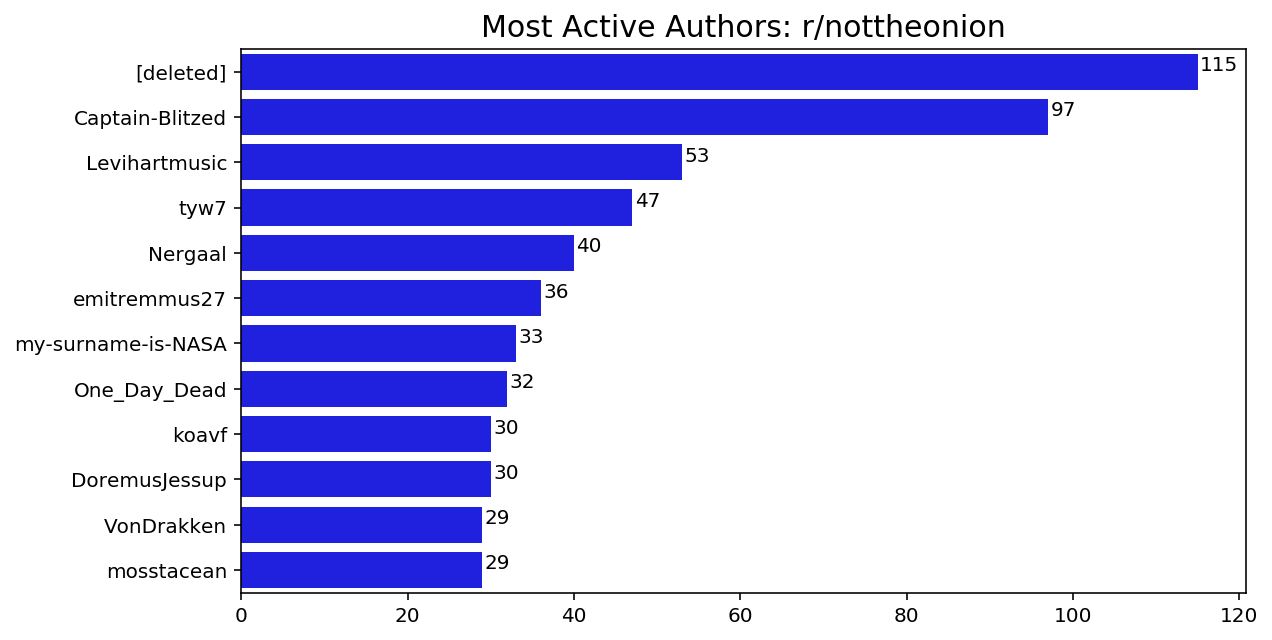

In [26]:
# Call function
bar_plot(df_not_onion_authors.values, df_not_onion_authors_index, 'Most Active Authors: r/nottheonion','b')

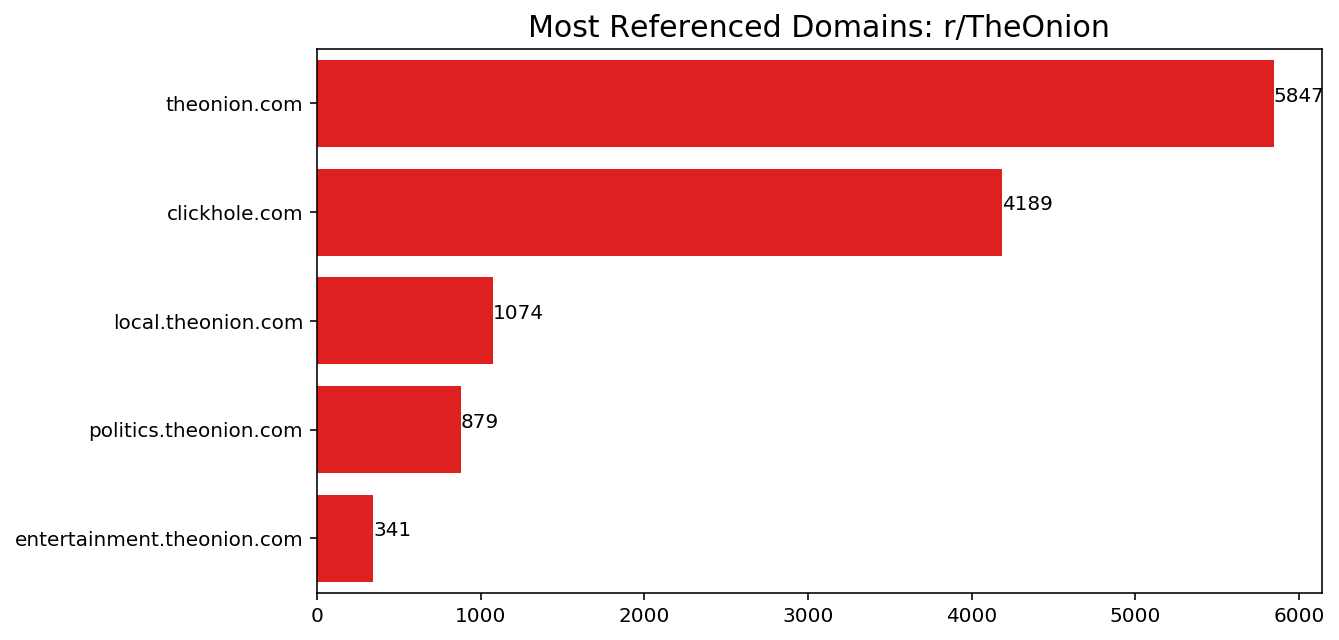

In [27]:
# Set x values: # of posts
df_onion_domain = df_onion['domain'].value_counts() 
df_onion_domain = df_onion_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_onion_domain_index = list(df_onion_domain.index)

# Call function
bar_plot(df_onion_domain.values, df_onion_domain_index, 'Most Referenced Domains: r/TheOnion','r')

Unsurprisingly, the most referenced domains from r/TheOnion are from The Onion. This subreddit allows articles from other news satire sites to be shared here as well.

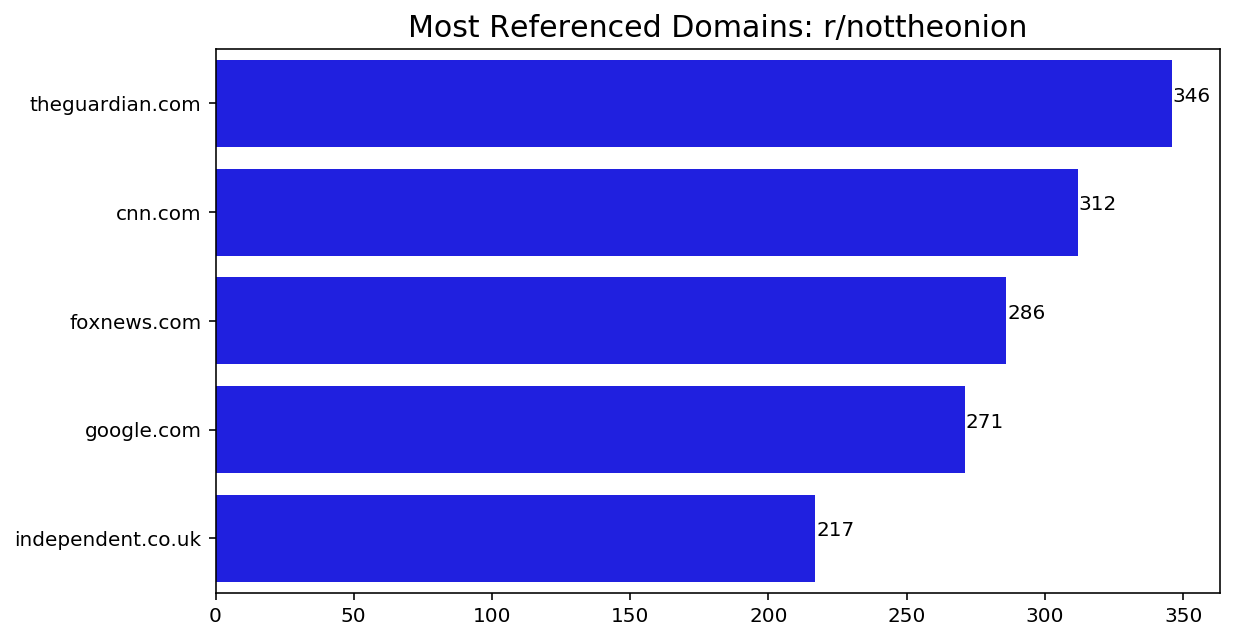

In [28]:
# Set x values: # of posts greater than 100
df_nonion_domain = df_not_onion['domain'].value_counts() 
df_nonion_domain = df_nonion_domain.sort_values(ascending=False).head(5)

# Set y values: Names of authors 
df_nonion_domain_index = list(df_nonion_domain.index)

# Call function
bar_plot(df_nonion_domain.values, df_nonion_domain_index, 'Most Referenced Domains: r/nottheonion','b')

theguardian.com is the most referenced domain in r/nottheonion!

Natural Language Processing (NLP):


Here I use Count Vectorizer to continue my EDA and explore the most used words and combinations of words from each subreddit.



In [29]:
# Combine df_onion & df_not_onion with only 'subreddit' (target) and 'title' (predictor) columns
df = pd.concat([df_onion[['subreddit', 'title']], df_not_onion[['subreddit', 'title']]], axis=0)

#Reset the index
df = df.reset_index(drop=True)

# Preview head of df to show 'TheOnion' titles appear
df.head(2)

,subreddit,title
0,TheOnion,cool it this high schooler is really milking t...
1,TheOnion,this article from should be archived as a cla...


In [30]:
# Preview head of df to show 'nottheonion' titles appear
df.tail(2)

,subreddit,title
26082,nottheonion,tupac superfan asked to resign from government...
26083,nottheonion,planned parenthood president forced out after ...


Binarize Target subreddit
TheOnion: 1
nottheonion: 0

In [31]:
# Replace `TheOnion` with 1, `nottheonion` with 0
df["subreddit"] = df["subreddit"].map({"nottheonion": 0, "TheOnion": 1})

# Print shape of df
print(df.shape)

# Preview head of df to show 1s
df.head(2)

(26084, 2)


,subreddit,title
0,1,cool it this high schooler is really milking t...
1,1,this article from should be archived as a cla...


In [32]:
# Preview tail of df to show 0s
df.tail(2)

,subreddit,title
26082,0,tupac superfan asked to resign from government...
26083,0,planned parenthood president forced out after ...


Count Vectorize df where subreddit is 1

ngram_range = (1,1)

In [33]:
# Set variables to show TheOnion Titles
mask_on = df['subreddit'] == 1
df_onion_titles = df[mask_on]['title']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
onion_cvec = cv1.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(14224, 13648)


Count Vectorize df where subreddit is 0

ngram_range = (1,1)

In [34]:
# Set variables to show NotTheOnion Titles
mask_no = df['subreddit'] == 0
df_not_onion_titles = df[mask_no]['title']

# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv2.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(11860, 14369)


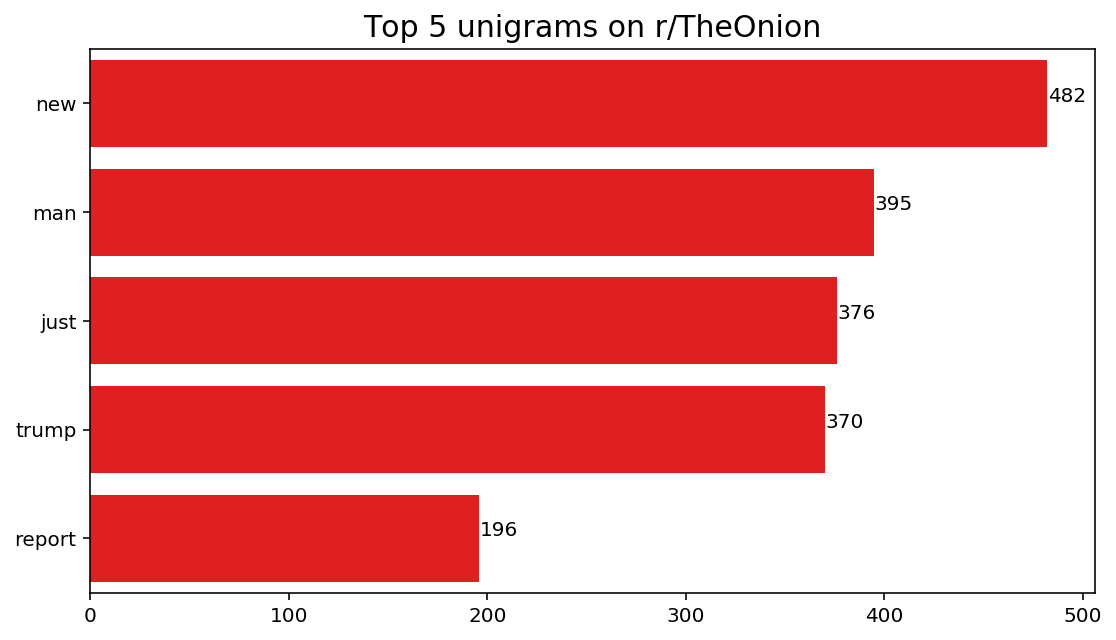

In [35]:
# Set up variables to contain top 5 most used words in Onion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 unigrams on r/TheOnion','r')

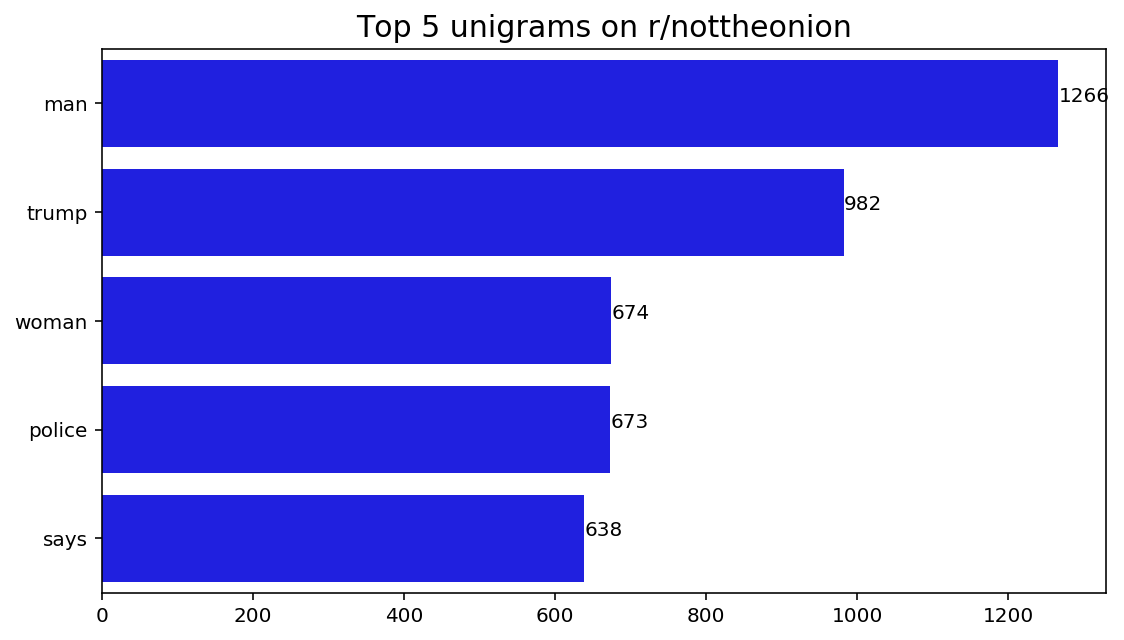

In [36]:
# Set up variables to contain top 5 most used words in Onion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 unigrams on r/nottheonion','b')

Common Unigrams between Top 5 in r/TheOnion & r/nottheonion


In [37]:
# Create list of unique words in top five
not_onion_5_set = set(nonion_top_5.index)
onion_5_set = set(onion_top_5.index)

# Return common words
common_unigrams = onion_5_set.intersection(not_onion_5_set)
common_unigrams

{'man', 'trump'}

Count Vectorize df where subreddit is 1

ngram_range = (2,2)

In [38]:
# Set variables to show TheOnion Titles
mask = df['subreddit'] == 1
df_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
onion_cvec = cv.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(14224, 44501)


Count Vectorize df where subreddit is 0

ngram_range = (2,2)

In [39]:
# Set variables to show NotTheOnion Titles
mask = df['subreddit'] == 0
df_not_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(11860, 58603)


r/TheOnion: Top 5 Bigrams

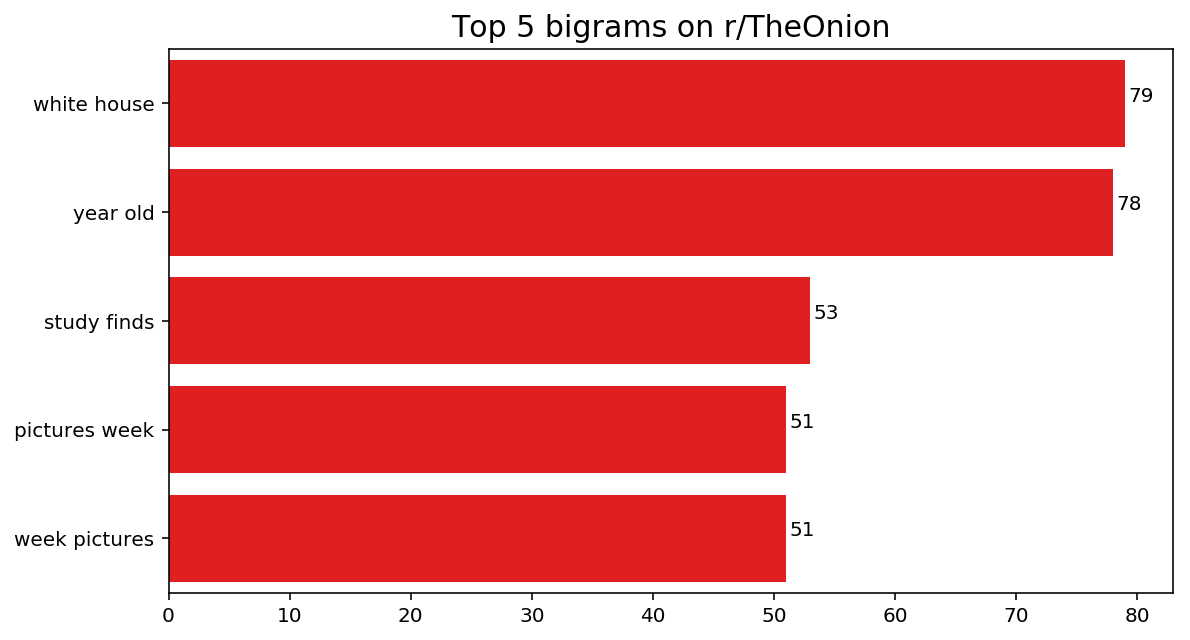

In [40]:
# Set up variables to contain top 5 most used bigrams in r/TheOnion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 bigrams on r/TheOnion','r')

r/nottheonion: Top 5 Bigrams

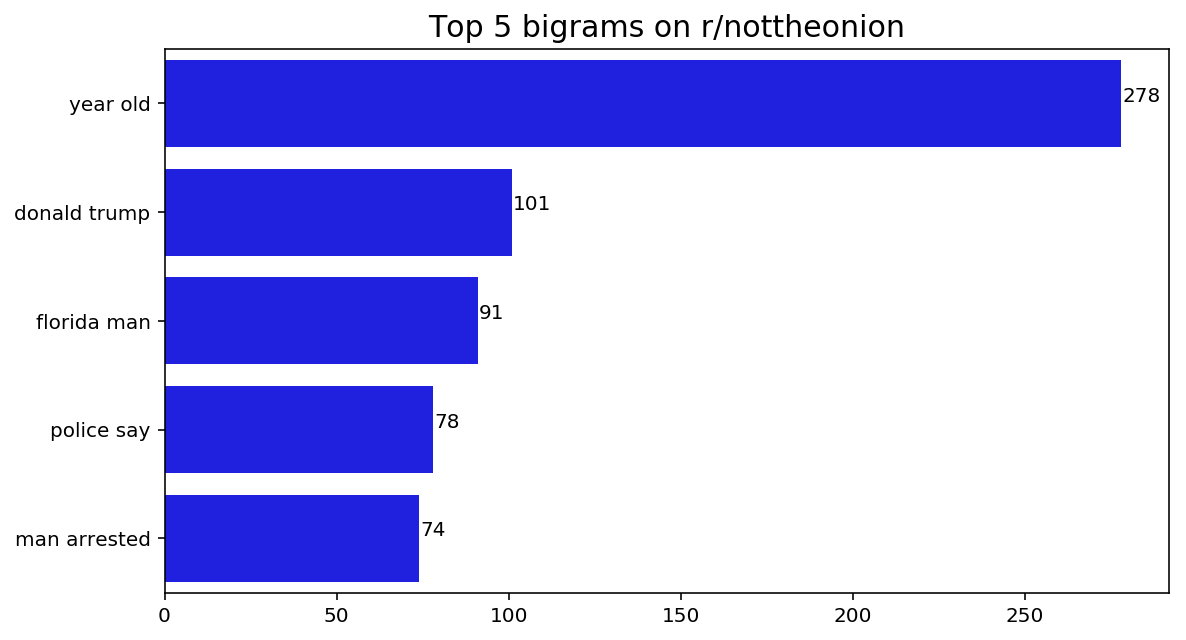

In [41]:
# Set up variables to contain top 5 most used bigrams in r/nottheonion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 bigrams on r/nottheonion','b')

Common Bigrams between Top 5 in r/TheOnion & r/nottheonion


In [42]:
not_onion_5_list = set(nonion_top_5.index)
onion_5_list = set(onion_top_5.index)

# Return common words
common_bigrams = onion_5_list.intersection(not_onion_5_list)
common_bigrams

{'year old'}

Take out {'man', 'new', 'old', 'people', 'say', 'trump', 'woman', 'year'} from dataset when modeling, since these words occur frequently in both subreddits.

Create custom stop_words to include common frequent words
Referencing the common most-used words, add them to a customized stop_words list.

In [43]:
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

Modeling
Here I conduct model-prep and use Pipeline and GridSearch to determine the most optimal model to run my data on.

Baseline Score

In [44]:
# Baseline score
df['subreddit'].value_counts(normalize=True)

1    0.545315
0    0.454685
Name: subreddit, dtype: float64

I expect my model to be better than 54%. The majority class is 1, or, TheOnion. If the model is not better than 54%, I know the model is not performing well.

In [45]:
#Set X (predictor) and y (target) variables
X = df['title']
y = df['subreddit']

In [46]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

Model 1: CountVectorizer & Logistic Regression (Best Coefficient Interpretability)


In [47]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_


Best score: 0.8504830547462046
Train score 0.9617645555385166
Test score 0.8521699125900936


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 1}

Throughout my model testing, none of the stop_word lists were chosen as a best parameter. So from here on out, I omit them from my parameter selection. Additionally, while the model is overfit, I am optimizing to get the highest accuracy score in my test set.

Model 2: TfidfVectorize & Logistic Regression


In [48]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_


Best score: 0.8411286612482748
Train score 0.9145325359096254
Test score 0.8446557276491335


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 3,
 'tvect__ngram_range': (1, 3)}

This model is also overfit. However, Model 1 performed with a better test score when comparing Logistic Regression models.



Model 3: CountVectorizer & MultinomialNB (Best Accuracy Score)

In [49]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8860093032765936
Train score 0.9968818688340234
Test score 0.8874405765986811


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.36}

The model is overfit, but as I mentioned, I am optimizing for accuracy. I want to ensure that all predictions are correct. That is, all posts from r/TheOnion must be classified as being from the subreddit r/TheOnion, and all posts from r/nottheonion must be classified as being from the subreddit r/nottheonion. This model gave me my best test accuracy score.

Model 4: TfidfVectorizer & MultinomialNB

In [50]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8568215508868783
Train score 0.9215355518069825
Test score 0.8526299647293359


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 2)}

This model is overfit. When comparing test scores of my MultinomialNB models, Model 3 performs better.


Best Models
In this section, I take my two optimal models and run them. The first model, CountVectorizer & MultinomialNB, will be used to convey a confusion matrix
which will show all evaluation scores. The second model, CountVectorizer & Logistic Regression, will be used to interpret my coefficients.

CountVectorizer & MultinomialNB: Best Score

In [51]:
#Instantiate the classifier and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

0.8874405765986811


Confusion Matrix

In [52]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[2583,  382],
       [ 352, 3204]])

Text(0.5, 257.44, 'Predicted label')

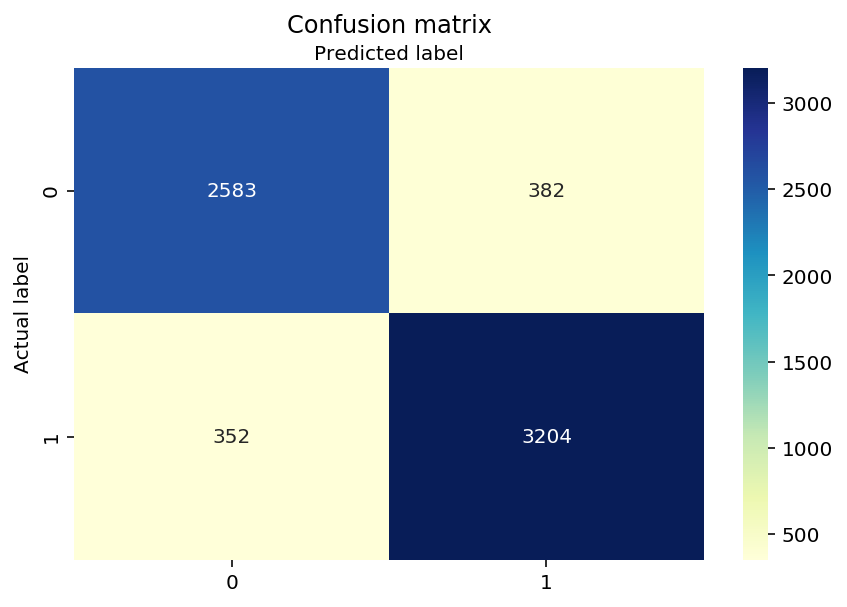

In [53]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [54]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [55]:
# Print Scores 

print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 88.74 %
Precision: 89.35 %
Recall: 90.1 %
Specificity: 87.12 %
Misclassification Rate: 12.44 %


CountVectorizer & Logistic Regression: Best Coefficient Interpretability


In [56]:
# Customize stop_words to include `onion` so that it doesn't appear
# in coefficients 

stop_words_onion = stop_words.ENGLISH_STOP_WORDS
stop_words_onion = list(stop_words_onion)
stop_words_onion.append('onion')

In [57]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec2 = CountVectorizer(stop_words = stop_words_onion)

# Fit and transform the vectorizor
cvec2.fit(X_train)

Xcvec2_train = cvec2.transform(X_train)
Xcvec2_test = cvec2.transform(X_test)

# Fit the classifier
lr.fit(Xcvec2_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec2_test)

print(lr.score(Xcvec2_test, y_test))

0.8484894954761539


Coefficient Analysis

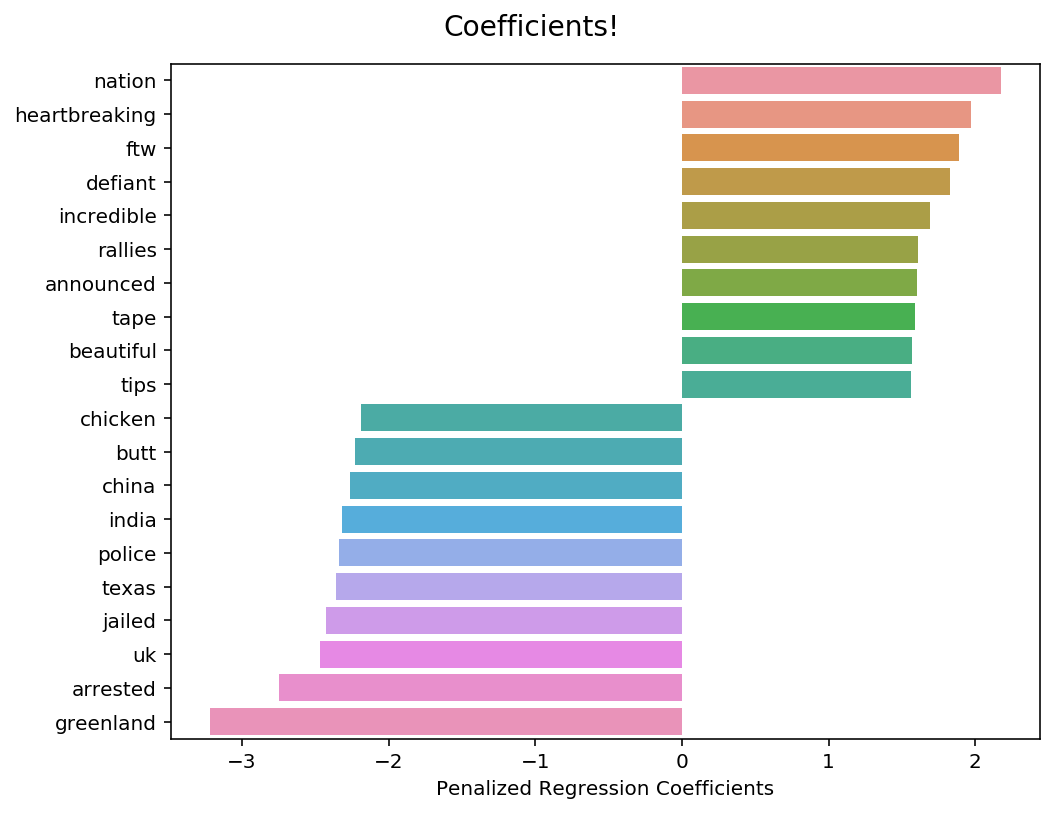

In [58]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec2.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# Jasmine changing things up here on out! Top half not mine. 
# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients!', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [59]:
print("The word that contributes the most positively to being from r/TheOnion is", 
      df_merged.index[0], "followed by", 
      df_merged.index[1], "and",
      df_merged.index[2],".")

print("-----------------------------------")

print("The word that contributes the most positively to being from r/nottheonion is", 
      df_merged.index[-1], "followed by", 
      df_merged.index[-2], "and",
      df_merged.index[-3],".")

The word that contributes the most positively to being from r/TheOnion is nation followed by heartbreaking and ftw .
-----------------------------------
The word that contributes the most positively to being from r/nottheonion is greenland followed by arrested and uk .


In [60]:
# Show coefficients that affect r/TheOnion
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
nation,2.174,8.793387
heartbreaking,1.972,7.185032
ftw,1.886,6.592944
defiant,1.830,6.233887
incredible,1.692,5.430331
rallies,1.608,4.992816
announced,1.601,4.957988
tape,1.588,4.893951
beautiful,1.567,4.792250
tips,1.560,4.758821


In [61]:
print("As occurences of", df_merged_head.index[0], "increase by 1 in a title, that title is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as r/TheOnion.")

As occurences of nation increase by 1 in a title, that title is 8.79 times as likely to be classified as r/TheOnion.


In [62]:
# Show coefficients that affect r/nottheonion
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
greenland,-3.217,24.953148
arrested,-2.751,15.658282
uk,-2.470,11.822447
jailed,-2.426,11.313537
texas,-2.359,10.580366
police,-2.342,10.402020
india,-2.317,10.145193
china,-2.267,9.650406
butt,-2.229,9.290571
chicken,-2.192,8.953101


In [63]:
print("As occurences of", df_merged_tail.index[-1], "increase by 1 in a title, that title is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as r/nottheonion.")

As occurences of greenland increase by 1 in a title, that title is 24.95 times as likely to be classified as r/nottheonion.


Conclusions and Next-Steps
The most model to optimize for accuracy in detecting fake news and absurd news uses CountVectorizer and MultinomialDB. The optimal parameters for this model are where ngram_range = (1,3) and alpha = 0.36.

Accuracy: 89.72%
Precision: 90.87%
Recall: 90.02%
Specificity: 89.38%
Misclassification Rate: 11.11%
To interpret my coefficients, I used my CountVectorizer & Logistic Regression model.

The word that contributes the most positively to being from r/TheOnion is 'incredible' followed by 'questions' and 'heartbreaking'.
As occurences of "incredible" increase by 1 in a title, that title is 10.32 times as likely to be classified as r/TheOnion.
The word that contributes the most positively to being from r/nottheonion is 'australia' followed by 'title' and 'florida'.
As occurences of "australia" increase by 1 in a title, that title is 15.03 times as likely to be classified as r/nottheonion.
Natural Language Processing of text is one way to analyze fake news, but a major gap exists: image & video analysis. For my next-steps, I am interested in being able to interpret media (images and videos) and classify them as authentic news, fake news, or none of the above (i.e., media for entertainment).